**IMDb**（Internet Movie Datebase ）是全球最大的互联网影视数据库，而[Large Movie Review Dataset](https://ai.stanford.edu/~amaas/data/sentiment/) 是一个根据IMDB上电影评论而建立的数据集。它由斯坦福大学于 2011 年发布。

![image-20201226152702981](images/image-20201226152702981.png)

## 获取数据

首先引入需要的包。

In [1]:
import matplotlib.pyplot as plt
import nltk
import numpy as np
import os
import pandas as pd
import random
import re
import shutil
import string  
import sys
import tensorflow as tf

from collections import Counter
from nltk.corpus import stopwords
from scipy import stats
from sklearn.feature_extraction import text
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split
from tensorflow.keras import Model, models, layers, regularizers, preprocessing, datasets, metrics, losses
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

base_path = '/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/code'
sys.path.append(base_path)

import util
from text_classification import lr_schedule
from text_classification import plot_distribution, plot_length_distribution, plot_frequency_distribution
from text_classification import Params, TextClassificationHelper
from text_classification import SimpleTextDatasets, SequenceTextDatasets, RawTextDatasets,TransferTextDatasets

# 代码自动重新加载
%load_ext autoreload
%autoreload 2

In [2]:
# 当module有新的方法的时候，需要运行下面方法。
%reload_ext autoreload

设置GPU最大内存。

In [3]:
util.set_gpu_memory_growth()
model_results={}

初始化参数。

In [4]:
def lr_schedule(epoch, lr):
    lr_times = [(0, 1), (60, 1e-1), (90, 1e-2), (105, 1e-3), (120, 0.5e-3)]
    
    base_lr = 1e-3
    new_lr = base_lr
    for border_epoch, times in lr_times:
        if epoch>=border_epoch: 
            new_lr = base_lr*times
    if abs(lr - new_lr)>1e-7:
        # ??lr?new_lr???????0.1??new_lr?????lr
        if new_lr > lr > 0.1*new_lr - 1e-7:
            print('Epoch %05d: Still keep learning rate %s instead of %s' % 
                  (epoch + 1, round(lr, 7), round(new_lr, 7))) 
            return lr   
        print('Epoch %05d: LearningRateScheduler reducing learning rate to %s from %s.' % 
              (epoch + 1, round(new_lr, 7), round(lr, 7)))
    return new_lr

nltk.download('stopwords')


params = {
    'dataset_name': 'reuters',
    'program_name': util.get_notebook_name(),
    'sample_perecent': 1,    
    'text_column': '',    
    'classes': ['csharp', 'java', 'javascript', 'python'],
    'validation_percent': 0.0,    
    'stop_words':stopwords.words('english'),
    'use_stop_words': True,    
    'batch_size': 32,    
    'max_features': 20000,
    'sequence_length': 500,    
    'epochs': 3,    
    'learning_rate':0.001,
    'dropout':0.1,
    'metrics':['accuracy', metrics.SparseTopKCategoricalAccuracy(k=2)], 
    'loss': losses.SparseCategoricalCrossentropy(from_logits=True),
    'restore_best_checkpoint':True,
    'use_savedmodel':True,
    'callbacks': {
        'ModelCheckpoint': {
            'enabled': True,
            'monitor': 'val_accuracy',               
        },
        'EarlyStopping': {
            'enabled': True,
            'patience': 40,   
            'monitor': 'val_accuracy',            
        },
        'ReduceLROnPlateau': {
            'enabled': True,
            'monitor': 'val_loss',
            'patience': 15,
            'factor': np.sqrt(0.1),            
        },
        'LearningRateScheduler': {
            'enabled': True,
            'schedule': lr_schedule,            
        }             
    },
    'model_params':{
        'mlp':{'dropout':0.6, 'layer_count':1, 'units':256, 'epochs':20},
        'rnn':{'dropout':0.3, 'embedding_dim':200, 'units':200, 'epochs':5},
        'embedding':{'dropout':0.4, 'embedding_dim':200, 'epochs':10},
        'sepcnn':{'dropout':0.4, 'epochs': 10, 'batch_size':128},
    }
}

params = Params(params)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### 下载数据

开始下载数据。

In [5]:
dataset_dir =  os.path.join(os.path.expanduser('~'), '.keras/datasets/stack_overflow_16k') 
if not os.path.exists(dataset_dir):
    url = "http://storage.googleapis.com/download.tensorflow.org/data/stack_overflow_16k.tar.gz"
    dataset = tf.keras.utils.get_file("stack_overflow_16k.tar.gz", url, untar=True, 
                                      cache_subdir='datasets/stack_overflow_16k')
print(dataset_dir)
util.show_tree(dataset_dir, max_depth=2) 

/root/.keras/datasets/stack_overflow_16k
/root/.keras/datasets/stack_overflow_16k
├──stack_overflow_16k.tar.gz.tar.gz
├──README.md
├──train
│   ├──python
│   ├──java
│   ├──csharp
│   └──javascript
└──test
    ├──python
    ├──java
    ├──csharp
    └──javascript




其中train和test目录包含了实际的文本数据，详细说明见[IMDB](https://eipi10.cn/others/2020/10/22/dataset/#imdb---large-movie-review-dataset)。

### 查看数据

下面看一看实际的数据是啥样的。

In [6]:
def get_files(base_dir):
    files = {}
    for folder in os.listdir(base_dir):
        class_dir = os.path.join(base_dir, folder)
        text_files = os.listdir(class_dir)
        files[folder] = [os.path.join(class_dir, file_name) for file_name in text_files]    
    return files

def show_files(files, title=''):
    print('-'*40, title, '-'*40)
    for class_dir, text_files in files.items():
        print('{}: {} files'.format(class_dir, len(text_files)))
        

train_files = get_files(os.path.join(dataset_dir, 'train'))
test_files = get_files(os.path.join(dataset_dir, 'test'))    
    
show_files(train_files, 'train')
show_files(test_files, 'test')

---------------------------------------- train ----------------------------------------
python: 2000 files
java: 2000 files
csharp: 2000 files
javascript: 2000 files
---------------------------------------- test ----------------------------------------
python: 2000 files
java: 2000 files
csharp: 2000 files
javascript: 2000 files


![image-20201217115036617](images/image-20201217115036617.png)

首先看一看正面的评论。

In [7]:
for class_dir, text_files in train_files.items():
    print('='*40, class_dir, '='*40)
    for file_path in text_files[0:2]:    
        print('-'*30 + os.path.basename(file_path) + '-'*30 )
        with open(file_path) as f:
            comment = f.read() 
            print(comment if len(comment)<=800 else comment[0:800]+' ...') 

======================================== python ========================================
------------------------------1053.txt------------------------------
"how to put multiple pickles files in a single pickle file i have two pickle files that are contain a list of numpy ndarrays...first pickle file:..{'encodings': [array([-0.18668848,  0.09167872,  0.02361359, -0.04610855, -0.11987427,.       -0.06734911,  0.00542389,  0.02105863,  0.17828396, -0.00141097,.        0.166828s45, -0.01075029, -0.20508201,  0.02762154, -0.00806585,.        0.098497  , -0.17736666, -0.11334869, -0.10142692, -0.1134191 ,.        0.06917755,  0.07989676, -0.04121129,  0.04280601, -0.12306173,.       -0.29819348, -0.07650399, -0.10041754,  0.02334423, -0.06270325,.        0.12638046,  0.10296188, -0.10587093, -0.08311734,  0.06213638,.        0.08304631, -0.03443629, -0.08486824,  0.23685798,  0.01827276,.       -0.10278646,  0.01152256,  0.08467054,  0.37257931,  0 ...
------------------------------1735.tx



## 探索数据

接下来，对把数据加载进内存，进行深入一些的探索。

### 基本信息

In [8]:
def get_samples(texts, labels, rate):
    indexs = np.arange(len(texts))
    sample_indexs, _, sample_labels, _ = train_test_split(indexs, labels,                                                          
                                                          test_size=1-rate,
                                                          random_state=12)
    sample_texts = [texts[index] for index in sample_indexs]
    return sample_texts, sample_labels    

def load_stack_overflow_16k_dataset(data_path, classes=params.classes, seed=123):
    def load_data(base_dir):
        texts = []
        labels = []
        for category in os.listdir(base_dir):
            category_path = os.path.join(base_dir, category)
            for fname in sorted(os.listdir(category_path)):
                if fname.endswith('.txt'):
                    with open(os.path.join(category_path, fname)) as f:
                        texts.append(f.read())
                    labels.append(classes.index(category) )
        return texts, labels

    train_texts, train_labels = load_data(os.path.join(data_path, 'train'))
    test_texts, test_labels = load_data(os.path.join(data_path, 'test'))

    # Shuffle the training data and labels.
    random.seed(seed)
    random.shuffle(train_texts)
    random.seed(seed)
    random.shuffle(train_labels)

    return ((train_texts, np.array(train_labels)),
            (test_texts, np.array(test_labels)))

(train_texts, train_labels), (test_texts, test_labels) = load_stack_overflow_16k_dataset(dataset_dir)

print('train_texts.length={}, train_labels.shape={}'.format(len(train_texts), train_labels.shape))
print('test_texts.length={}, test_labels.shape={}'.format(len(test_texts), test_labels.shape))

if params.sample_perecent<1:
    train_texts, train_labels = get_samples(train_texts, train_labels, rate=params.sample_perecent)
    test_texts, test_labels = get_samples(test_texts, test_labels, rate=params.sample_perecent)

print('train_texts.length={}, train_labels.shape={}'.format(len(train_texts), train_labels.shape))
print('test_texts.length={}, test_labels.shape={}'.format(len(test_texts), test_labels.shape))

train_texts.length=8000, train_labels.shape=(8000,)
test_texts.length=8000, test_labels.shape=(8000,)
train_texts.length=8000, train_labels.shape=(8000,)
test_texts.length=8000, test_labels.shape=(8000,)


In [9]:
test_texts[0]

'"variables keep changing back to their original value inside a while loop i am doing the mitx 6.00.01x course and i am on the second problem set on the 3rd problem and i am stuck. .my code:  ..    balance = 320000.    annualinterestrate = 0.2.    monthlyinterestrate = (annualinterestrate) / 12.0.    monthlyfixedpayment = 0.    empbalance = balance.    lowerbound = round((balance)/12,2).    upperbound = (balance*(1+monthlyinterestrate)**12)/12.    monthlyfixedpayment = round( ( (lowerbound+upperbound)/2) ,2).    while tempbalance != 0: .        monthlyfixedpayment = round( ( (lowerbound+upperbound)/2) ,2)  .        for m in range(12) :.            tempbalance -= monthlyfixedpayment .            tempbalance += (monthlyinterestrate)*(tempbalance).            tempbalance = round(tempbalance,2) .        if tempbalance &gt; 0:.            lowerbound = round(monthlyfixedpayment,2).            tempbalance = balance.        elif tempbalance &lt; 0: .            upperbound = round(monthlyfixedp



### 类别分布

下面看看类别的分布。可以看到数据分为Positive和Negative两类，数据分布完全均匀。

In [10]:
len(params.classes)

4

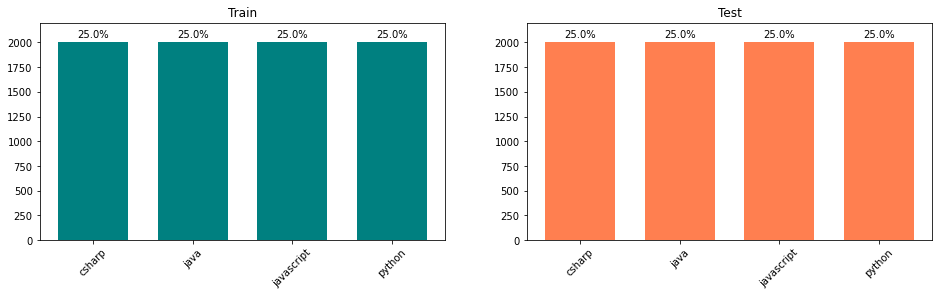

In [11]:
plot_distribution(train_labels, test_labels, params.classes)



### 文本长度分布

分析训练集和测试集的文本长度分布是否相似。

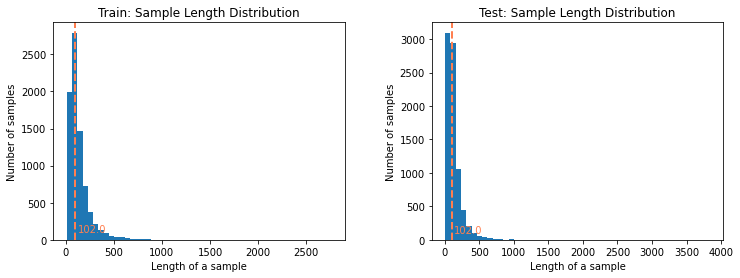

train：mean=137.06 variance=16491.97
test：mean=133.22 variance=14516.98


In [12]:
train_text_lengths = [len(s.split()) for s in train_texts]
test_text_lengths = [len(s.split()) for s in test_texts]
plot_length_distribution(train_text_lengths, test_text_lengths)

print('train：mean={:0.2f} variance={:0.2f}'.format(np.mean(train_text_lengths), 
                                                    np.var(train_text_lengths)))
print('test：mean={:0.2f} variance={:0.2f}'.format(np.mean(test_text_lengths), 
                                                   np.var(test_text_lengths)))



通过图形，中位数，均值和方差的比较，可以认为训练集和测试集文本长度的分布是非常相似的。下面用卡方检验来比较训练集和测试集是否有显著差异。

In [13]:
def process_length(lengths):
    cut_points = [0,99,199,299,399,499,599,699,799,10000]
    labels = ["0-99","100-199","200-299","300-399","400-499","500-599", "600-699","700-799","800+"]
    return pd.cut(lengths, cut_points, labels=labels)

def get_observed(df, column1, column2):
    df_observed = pd.crosstab(
        df[column1],
        df[column2]
    )    
    return df_observed
    
def get_expected(df_observed):
    observed = df_observed.to_numpy()
    reduce_row = observed.sum(axis=0, keepdims=True)/observed.sum()
    reduce_col = observed.sum(axis=1, keepdims=True)

    expected = reduce_col.dot(reduce_row)
    df_expected = pd.DataFrame(expected, index=df_observed.index, columns=df_observed.columns)
    return df_expected
  
def show_sum(df):
    df.columns =  df.columns.tolist()  
    df = df.reset_index()
    s = df.melt(df.columns[0], var_name=' ')
    ct = pd.crosstab(index=s[df.columns[0]], columns=s.iloc[:,1], values=s.value, 
                     aggfunc='sum', margins=True, margins_name='合计',
                     rownames=[''], 
               ) 
    display(ct)
    
length = train_text_lengths + test_text_lengths
dataset = ['train']*len(train_text_lengths) + ['test']*len(test_text_lengths)

df_length = pd.DataFrame({"dataset":dataset, "length":length})
df_length['len'] = process_length(length)
df_observed = get_observed(df_length, 'dataset', 'len')
# display(df_length)

print('-'*25, 'Observed', '-'*25)
show_sum(df_observed)

print('-'*25, 'Expected', '-'*25)
df_expected = get_expected(df_observed)
show_sum(df_expected)

------------------------- Observed -------------------------


,0-99,100-199,200-299,300-399,400-499,500-599,600-699,700-799,800+,合计
,,,,,,,,,,
test,3868,2836,772,283,113,54,36,12,26,8000
train,3885,2742,782,295,131,68,38,22,37,8000
合计,7753,5578,1554,578,244,122,74,34,63,16000


------------------------- Expected -------------------------


,0-99,100-199,200-299,300-399,400-499,500-599,600-699,700-799,800+,合计
,,,,,,,,,,
test,3876.5,2789.0,777.0,289.0,122.0,61.0,37.0,17.0,31.5,8000.0
train,3876.5,2789.0,777.0,289.0,122.0,61.0,37.0,17.0,31.5,8000.0
合计,7753.0,5578.0,1554.0,578.0,244.0,122.0,74.0,34.0,63.0,16000.0


![image-20210101174143400](images/image-20210101174143400.png)

然后进行卡方检验。可以看到p_value>0.05，所以接受原假设——数据集来源和文本长度是独立的，也就是说接受训练集和测试集是是相似的分布。

In [14]:
observed = df_observed.to_numpy()
expected = df_expected.to_numpy()

chi_squared_stat = ((observed-expected)**2/expected).sum()
print('chi_squared_stat =', chi_squared_stat)

df = np.prod(np.array(observed.shape) - 1)
critical_value  = stats.chi2.ppf(q=0.95, df=df)  #0.95:置信水平, df:自由度
print('critical_value =', critical_value)        #临界值:拒绝域的边界, 当卡方值大于临界值，则原假设不成立，备择假设成立

p_value = 1 - stats.chi2.cdf(x=chi_squared_stat, df=df)
print('p_value =', p_value)

chi_squared_stat = 9.785132895960267
critical_value = 15.50731305586545
p_value = 0.2804318778573175


![image-20210101174317709](images/image-20210101174317709.png)

### 词频分布

分析训练集和测试集的词频分布是否相似。下面代码中，去除了一些stopwords。

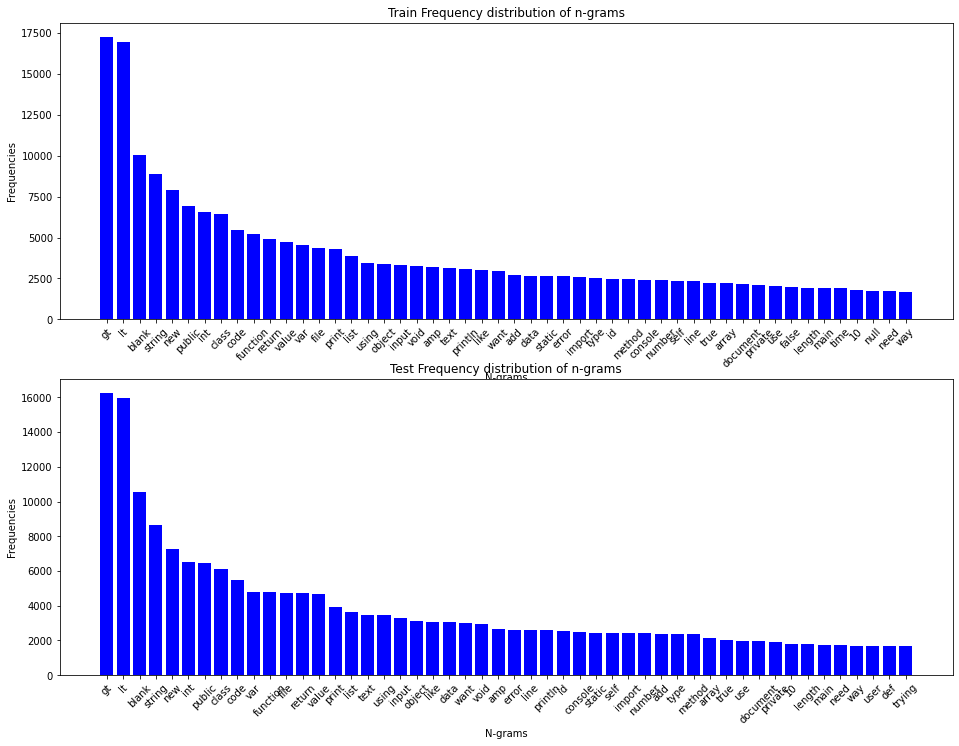

In [15]:
plot_frequency_distribution(train_texts, test_texts)

![image-20201217134151280](images/image-20201217134151280.png)

In [16]:
word_counter = Counter()
for s in train_texts:
    word_counter.update(s.split())
for s in test_texts:
    word_counter.update(s.split())   

print('Number of Vocabulary: {}'.format(len(word_counter)))

for word in list(word_counter):
    if word_counter[word]<25: word_counter.pop(word)
        
print('Number of Vocabulary: {}'.format(len(word_counter)))

Number of Vocabulary: 337733
Number of Vocabulary: 4670


![image-20201217142728260](images/image-20201217142728260.png)

上面可以看到词频大于等于100次的词汇有7706个。

## 准备数据

不同的模型需要准备不同的数据，所以徐要确定一下要构建哪种模型。

### 模型选择

下图是google在两年前提出一个选择流程图。

![image-20201217135347743](images/image-20201217135347743.png)

1. Calculate the number of samples/number of words per sample ratio.
2. If this ratio is less than 1500, tokenize the text as n-grams and use a simple multi-layer perceptron (MLP) model to classify them (left branch in the flowchart below):
   a. Split the samples into word n-grams; convert the n-grams into vectors.
     b. Score the importance of the vectors and then select the top 20K using the scores.
   c. Build an MLP model.
3. If the ratio is greater than 1500, tokenize the text as sequences and use a sepCNN model to classify them (right branch in the flowchart below):
   a. Split the samples into words; select the top 20K words based on their frequency.
   b. Convert the samples into word sequence vectors.
   c. If the original number of samples/number of words per sample ratio is less   than 15K, using a fine-tuned pre-trained embedding with the sepCNN  model will likely provide the best results.
4. Measure the model performance with different hyperparameter values to find
   the best model configuration for the dataset.

In [17]:
length_median = np.median(train_text_lengths)
train_number = len(train_texts)
print ("[the number of samples]/[number of words per sample] = {:0.1f}".format(train_number/length_median))

[the number of samples]/[number of words per sample] = 78.4


![image-20201217144321430](images/image-20201217144321430.png)

可以看到这个比例大大小于143.7，所以我们从N-gram模型开始，但是同时我们也会为Sequence模型准备数据。数据准备有如下两个过程。

- Tokenization：把文本转化成Token
- Vectorization： 把Token变成Vector

接下来，我们将分别为N-gram模型和Sequence模型准备数据。

### N-gram

在N-gram模型中，Tokenization一般使用unigrams + bigrams的方式把文本转成Token，而Vectorization过程，一般先统计Token的BOW（Bag of Words，词袋模型），然后采用tf-idf在对词频进行平衡。

In [18]:
ngram_vectorizer = util.NgramVectorizer()
if params.use_stop_words:
    ngram_vectorizer.fit(train_texts, train_labels,
                         top_k=params.max_features, ngram_range=(1, 2),
                         stop_words=params.stop_words)
else:
    ngram_vectorizer.fit(train_texts, train_labels,
                         top_k=params.max_features, ngram_range=(1, 2),
                         stop_words=None)

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:1808: UserWarning: Only (<class 'numpy.float64'>, <class 'numpy.float32'>, <class 'numpy.float16'>) 'dtype' should be used. int32 'dtype' will be converted to np.float64.
  UserWarning)


![image-20210102091446193](images/image-20210102091446193.png)

可以看到上面数据是以稀疏矩阵的形式存在的。下面创建ngram数据集。

In [19]:
ngram_datasets = SimpleTextDatasets(params, train_texts, train_labels, test_texts, test_labels, ngram_vectorizer)
                               
train_ngram = ngram_datasets.train_data
test_ngram = ngram_datasets.test_data
    
print(train_ngram.shape, type(train_ngram), train_ngram.dtype)
print(test_ngram.shape, type(test_ngram), test_ngram.dtype)
print(train_ngram[0, 0:1000])                               

save object to ./models/reuters/stack_overflow_16k_0329_p100/SimpleTextDatasets.vectorizer
create train, validation and test dataset
(8000, 20000) <class 'scipy.sparse.csr.csr_matrix'> float32
(8000, 20000) <class 'scipy.sparse.csr.csr_matrix'> float32
  (0, 128)	0.021007366


### Sequence

![Embedding Layer](images/EmbeddingLayer.png)

如上图所示，和N-gram模型不同，Sequence模型并不统计词频，它保持了文本的原始顺序，把其中的每个词汇单独变成一个One-hot向量，然后采用Word embedding的方式生成更加有意义的词向量，最后输出到RNN，CNN等模型中。下面将采用两种方式生成Sequence向量。

- Tokenizer
- TextVectorization

#### Tokenizer

In [20]:
sequence_vectorizer = util.SequenceVectorizer()
sequence_vectorizer.fit(train_texts, num_words=params.max_features, 
                        max_sequence_length =params.sequence_length)

![image-20210102105418015](images/image-20210102105418015.png)

创建sequence数据集。

In [21]:
sequence_datasets = SequenceTextDatasets(params, train_texts, train_labels, test_texts, test_labels, sequence_vectorizer)

train_seq = sequence_datasets.train_data
test_seq = sequence_datasets.test_data

print(train_seq.shape, type(train_seq), train_seq.dtype)
print(test_seq.shape, type(test_seq), test_seq.dtype)
print(test_seq[1][0:500])

save object to ./models/reuters/stack_overflow_16k_0329_p100/SequenceTextDatasets.vectorizer
create train, validation and test dataset
(8000, 500) <class 'numpy.ndarray'> int32
(8000, 500) <class 'numpy.ndarray'> int32
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0




##  模型

### MLP

In [22]:
def sparse_to_dense(value):
    if isinstance(value, tf.sparse.SparseTensor):
        return tf.sparse.to_dense(value)
    return value

def get_mlp(helper, dropout=None, name='mlp'):
    """Creates an instance of a multi-layer perceptron model"""
    if dropout is None:
        dropout = helper.get_model_param(name, 'dropout')
    layer_count = helper.get_model_param(name, 'layer_count')
    units = helper.get_model_param(name, 'units')    
    
    input = layers.Input(shape=helper.datasets.input_shape)    
    x = tf.keras.layers.Lambda(sparse_to_dense)(input)
    if dropout>0: x = layers.Dropout(dropout)(x)
        
    for _ in range(layer_count):
        x = layers.Dense(units, activation='relu')(x)
        if dropout>0: x = layers.Dropout(dropout)(x)
    x = layers.Dense(len(helper.params.classes))(x)  
    
    model = Model(inputs=input, outputs=x, name=name)     
    helper.compile(model)   
    return model

helper = TextClassificationHelper(params, model_results=model_results, datasets=ngram_datasets)
model = get_mlp(helper)
model.summary()

model_params.mlp.dropout=0.6
model_params.mlp.layer_count=1
model_params.mlp.units=256
learning_rate=0.001
checkpoint_path=./models/reuters/stack_overflow_16k_0329_p100/mlp
Model: "mlp"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 20000)]           0         
_________________________________________________________________
lambda (Lambda)              (None, 20000)             0         
_________________________________________________________________
dropout (Dropout)            (None, 20000)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               5120256   
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)       

2021-04-02 17:43:52,830: INFO: start training


model_params.mlp.epochs=20
use ModelCheckpoint(filepath=./models/reuters/stack_overflow_16k_0329_p100/mlp, monitor=val_accuracy)
use EarlyStopping(monitor=val_accuracy, patience=40)
use ReduceLROnPlateau(monitor=val_loss, factor=0.31622776601683794, patience=15)
use LearningRateScheduler()
Epoch 1/20
248/250 [============================>.] - ETA: 0s - loss: 0.9794 - accuracy: 0.6990 - sparse_top_k_categorical_accuracy: 0.8532WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/training/tracking/tracking.py:111: Model.state_updates (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


2021-04-02 17:43:56,877: WARNING: From /usr/local/lib/python3.6/dist-packages/tensorflow/python/training/tracking/tracking.py:111: Model.state_updates (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


2021-04-02 17:43:56,903: WARNING: From /usr/local/lib/python3.6/dist-packages/tensorflow/python/training/tracking/tracking.py:111: Layer.updates (from tensorflow.python.keras.engine.base_layer) is deprecated and will be removed in a future version.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


INFO:tensorflow:Assets written to: ./models/reuters/stack_overflow_16k_0329_p100/mlp/assets


2021-04-02 17:43:57,768: INFO: Assets written to: ./models/reuters/stack_overflow_16k_0329_p100/mlp/assets


250/250 [==============================] - 4s 17ms/step - loss: 0.9767 - accuracy: 0.6996 - sparse_top_k_categorical_accuracy: 0.8536 - val_loss: 0.5284 - val_accuracy: 0.8671 - val_sparse_top_k_categorical_accuracy: 0.9535
Epoch 2/20
248/250 [============================>.] - ETA: 0s - loss: 0.5028 - accuracy: 0.8296 - sparse_top_k_categorical_accuracy: 0.9320INFO:tensorflow:Assets written to: ./models/reuters/stack_overflow_16k_0329_p100/mlp/assets


2021-04-02 17:44:01,678: INFO: Assets written to: ./models/reuters/stack_overflow_16k_0329_p100/mlp/assets


250/250 [==============================] - 4s 16ms/step - loss: 0.5018 - accuracy: 0.8301 - sparse_top_k_categorical_accuracy: 0.9324 - val_loss: 0.3666 - val_accuracy: 0.8834 - val_sparse_top_k_categorical_accuracy: 0.9574
Epoch 3/20
246/250 [============================>.] - ETA: 0s - loss: 0.3835 - accuracy: 0.8662 - sparse_top_k_categorical_accuracy: 0.9494INFO:tensorflow:Assets written to: ./models/reuters/stack_overflow_16k_0329_p100/mlp/assets


2021-04-02 17:44:05,110: INFO: Assets written to: ./models/reuters/stack_overflow_16k_0329_p100/mlp/assets


250/250 [==============================] - 3s 14ms/step - loss: 0.3834 - accuracy: 0.8665 - sparse_top_k_categorical_accuracy: 0.9494 - val_loss: 0.3210 - val_accuracy: 0.8875 - val_sparse_top_k_categorical_accuracy: 0.9582
Epoch 4/20
250/250 [==============================] - ETA: 0s - loss: 0.3240 - accuracy: 0.8873 - sparse_top_k_categorical_accuracy: 0.9586INFO:tensorflow:Assets written to: ./models/reuters/stack_overflow_16k_0329_p100/mlp/assets


2021-04-02 17:44:08,939: INFO: Assets written to: ./models/reuters/stack_overflow_16k_0329_p100/mlp/assets


250/250 [==============================] - 4s 15ms/step - loss: 0.3240 - accuracy: 0.8873 - sparse_top_k_categorical_accuracy: 0.9586 - val_loss: 0.3037 - val_accuracy: 0.8900 - val_sparse_top_k_categorical_accuracy: 0.9586
Epoch 5/20
249/250 [============================>.] - ETA: 0s - loss: 0.2928 - accuracy: 0.8962 - sparse_top_k_categorical_accuracy: 0.9636INFO:tensorflow:Assets written to: ./models/reuters/stack_overflow_16k_0329_p100/mlp/assets


2021-04-02 17:44:12,325: INFO: Assets written to: ./models/reuters/stack_overflow_16k_0329_p100/mlp/assets


250/250 [==============================] - 3s 13ms/step - loss: 0.2927 - accuracy: 0.8960 - sparse_top_k_categorical_accuracy: 0.9636 - val_loss: 0.2961 - val_accuracy: 0.8930 - val_sparse_top_k_categorical_accuracy: 0.9592
Epoch 6/20
250/250 [==============================] - 2s 9ms/step - loss: 0.2673 - accuracy: 0.9038 - sparse_top_k_categorical_accuracy: 0.9693 - val_loss: 0.2959 - val_accuracy: 0.8865 - val_sparse_top_k_categorical_accuracy: 0.9579
Epoch 7/20
250/250 [==============================] - 2s 10ms/step - loss: 0.2400 - accuracy: 0.9149 - sparse_top_k_categorical_accuracy: 0.9695 - val_loss: 0.2965 - val_accuracy: 0.8886 - val_sparse_top_k_categorical_accuracy: 0.9594
Epoch 8/20
250/250 [==============================] - 2s 10ms/step - loss: 0.2212 - accuracy: 0.9190 - sparse_top_k_categorical_accuracy: 0.9722 - val_loss: 0.2980 - val_accuracy: 0.8876 - val_sparse_top_k_categorical_accuracy: 0.9567
Epoch 9/20
250/250 [==============================] - 3s 10ms/step - los

2021-04-02 17:44:51,895: INFO: finish training [elapsed time: 59.07 seconds]


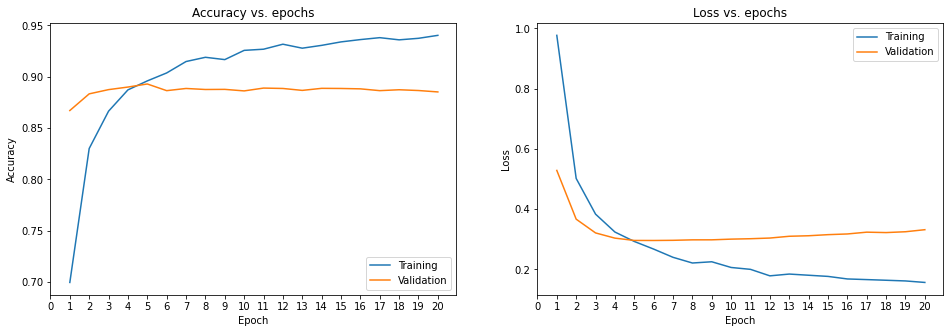

In [23]:
history = helper.train(model)

---------------------------------------- evaluate ----------------------------------------
load best checkpoint from ./models/reuters/stack_overflow_16k_0329_p100/mlp
learning_rate=0.001
checkpoint_path=./models/reuters/stack_overflow_16k_0329_p100/mlp
250/250 [==============================] - 1s 4ms/step - loss: 0.2961 - accuracy: 0.8930 - sparse_top_k_categorical_accuracy: 0.9592
loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/models/reuters/stack_overflow_16k_0329_p100/mlp
loading load_vectorizer from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/models/reuters/stack_overflow_16k_0329_p100/SimpleTextDatasets.vectorizer
save object to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/models/reuters/stack_overflow_16k_0329_p100/mlp.predictor
--------------------------------------------------------------------------------
test loss:0.2961
test accuracy:0.8930
test sparse_top_k_categorical_accuracy:0.9592
-----------------------------

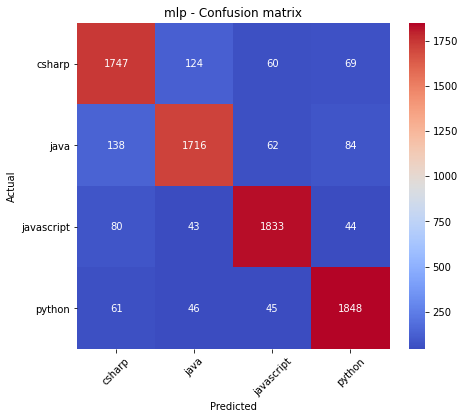

-------------------------------------------------- all models --------------------------------------------------


,weight_number,train_time,train_loss,test_loss,train_accuracy,test_accuracy,train_sparse_top_k_categorical_accuracy,test_sparse_top_k_categorical_accuracy
mlp,5121284,59.0,0.1314,0.2961,0.9722,0.893,0.9744,0.9592


save json to ./models/reuters/stack_overflow_16k_0329_p100/model_results.json


In [24]:
helper.model_summary(model, history=history)

### Embedding

In [25]:
def get_embedding(helper,
                 embedding_dim=None,
                 dropout=None,
                 name='embedding'
                ):

    if dropout is None:
        dropout = helper.get_model_param(name, 'dropout')
    if embedding_dim is None:
        embedding_dim = helper.get_model_param(name, 'embedding_dim')        
        
    input_shape = helper.datasets.input_shape
    num_classes = len(helper.params.classes)
    num_features = helper.params.max_features+1  
    
    model = models.Sequential(name=name)
    model.add(layers.Embedding(input_dim=num_features,
                               output_dim=embedding_dim,
                               input_length=input_shape[0]))
    model.add(layers.GlobalAveragePooling1D())
    if dropout>0: model.add(layers.Dropout(rate=dropout))
    model.add(layers.Dense(num_classes))
    helper.compile(model)  
    return model


helper = TextClassificationHelper(params, model_results=model_results, datasets=sequence_datasets)
model = get_embedding(helper)
model.summary()

model_params.embedding.dropout=0.4
model_params.embedding.embedding_dim=200
learning_rate=0.001
checkpoint_path=./models/reuters/stack_overflow_16k_0329_p100/embedding
Model: "embedding"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 500, 200)          4000200   
_________________________________________________________________
global_average_pooling1d (Gl (None, 200)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 804       
Total params: 4,001,004
Trainable params: 4,001,004
Non-trainable params: 0
_________________________________________________________________


2021-04-02 17:44:57,878: INFO: start training


model_params.embedding.epochs=10
use ModelCheckpoint(filepath=./models/reuters/stack_overflow_16k_0329_p100/embedding, monitor=val_accuracy)
use EarlyStopping(monitor=val_accuracy, patience=40)
use ReduceLROnPlateau(monitor=val_loss, factor=0.31622776601683794, patience=15)
use LearningRateScheduler()
Epoch 1/10
249/250 [============================>.] - ETA: 0s - loss: 1.3307 - accuracy: 0.4253 - sparse_top_k_categorical_accuracy: 0.8111INFO:tensorflow:Assets written to: ./models/reuters/stack_overflow_16k_0329_p100/embedding/assets


2021-04-02 17:45:09,017: INFO: Assets written to: ./models/reuters/stack_overflow_16k_0329_p100/embedding/assets


250/250 [==============================] - 10s 42ms/step - loss: 1.3304 - accuracy: 0.4257 - sparse_top_k_categorical_accuracy: 0.8111 - val_loss: 1.2506 - val_accuracy: 0.5440 - val_sparse_top_k_categorical_accuracy: 0.8234
Epoch 2/10
250/250 [==============================] - ETA: 0s - loss: 1.1110 - accuracy: 0.6729 - sparse_top_k_categorical_accuracy: 0.8554INFO:tensorflow:Assets written to: ./models/reuters/stack_overflow_16k_0329_p100/embedding/assets


2021-04-02 17:45:18,781: INFO: Assets written to: ./models/reuters/stack_overflow_16k_0329_p100/embedding/assets


250/250 [==============================] - 10s 39ms/step - loss: 1.1110 - accuracy: 0.6729 - sparse_top_k_categorical_accuracy: 0.8554 - val_loss: 0.9980 - val_accuracy: 0.7426 - val_sparse_top_k_categorical_accuracy: 0.9076
Epoch 3/10
249/250 [============================>.] - ETA: 0s - loss: 0.8687 - accuracy: 0.7730 - sparse_top_k_categorical_accuracy: 0.9089INFO:tensorflow:Assets written to: ./models/reuters/stack_overflow_16k_0329_p100/embedding/assets


2021-04-02 17:45:28,736: INFO: Assets written to: ./models/reuters/stack_overflow_16k_0329_p100/embedding/assets


250/250 [==============================] - 10s 40ms/step - loss: 0.8680 - accuracy: 0.7730 - sparse_top_k_categorical_accuracy: 0.9091 - val_loss: 0.8069 - val_accuracy: 0.7814 - val_sparse_top_k_categorical_accuracy: 0.9145
Epoch 4/10
250/250 [==============================] - ETA: 0s - loss: 0.7019 - accuracy: 0.8220 - sparse_top_k_categorical_accuracy: 0.9299INFO:tensorflow:Assets written to: ./models/reuters/stack_overflow_16k_0329_p100/embedding/assets


2021-04-02 17:45:38,615: INFO: Assets written to: ./models/reuters/stack_overflow_16k_0329_p100/embedding/assets


250/250 [==============================] - 10s 39ms/step - loss: 0.7019 - accuracy: 0.8220 - sparse_top_k_categorical_accuracy: 0.9299 - val_loss: 0.6818 - val_accuracy: 0.8141 - val_sparse_top_k_categorical_accuracy: 0.9311
Epoch 5/10
250/250 [==============================] - 9s 36ms/step - loss: 0.5897 - accuracy: 0.8470 - sparse_top_k_categorical_accuracy: 0.9435 - val_loss: 0.6052 - val_accuracy: 0.8141 - val_sparse_top_k_categorical_accuracy: 0.9212
Epoch 6/10
250/250 [==============================] - ETA: 0s - loss: 0.5084 - accuracy: 0.8662 - sparse_top_k_categorical_accuracy: 0.9514INFO:tensorflow:Assets written to: ./models/reuters/stack_overflow_16k_0329_p100/embedding/assets


2021-04-02 17:45:57,416: INFO: Assets written to: ./models/reuters/stack_overflow_16k_0329_p100/embedding/assets


250/250 [==============================] - 10s 39ms/step - loss: 0.5084 - accuracy: 0.8662 - sparse_top_k_categorical_accuracy: 0.9514 - val_loss: 0.5466 - val_accuracy: 0.8316 - val_sparse_top_k_categorical_accuracy: 0.9413
Epoch 7/10
248/250 [============================>.] - ETA: 0s - loss: 0.4473 - accuracy: 0.8847 - sparse_top_k_categorical_accuracy: 0.9606INFO:tensorflow:Assets written to: ./models/reuters/stack_overflow_16k_0329_p100/embedding/assets


2021-04-02 17:46:07,195: INFO: Assets written to: ./models/reuters/stack_overflow_16k_0329_p100/embedding/assets


250/250 [==============================] - 10s 39ms/step - loss: 0.4464 - accuracy: 0.8852 - sparse_top_k_categorical_accuracy: 0.9606 - val_loss: 0.5047 - val_accuracy: 0.8404 - val_sparse_top_k_categorical_accuracy: 0.9411
Epoch 8/10
249/250 [============================>.] - ETA: 0s - loss: 0.4012 - accuracy: 0.8938 - sparse_top_k_categorical_accuracy: 0.9647INFO:tensorflow:Assets written to: ./models/reuters/stack_overflow_16k_0329_p100/embedding/assets


2021-04-02 17:46:16,875: INFO: Assets written to: ./models/reuters/stack_overflow_16k_0329_p100/embedding/assets


250/250 [==============================] - 10s 38ms/step - loss: 0.4009 - accuracy: 0.8941 - sparse_top_k_categorical_accuracy: 0.9647 - val_loss: 0.4732 - val_accuracy: 0.8476 - val_sparse_top_k_categorical_accuracy: 0.9471
Epoch 9/10
250/250 [==============================] - ETA: 0s - loss: 0.3613 - accuracy: 0.9097 - sparse_top_k_categorical_accuracy: 0.9694INFO:tensorflow:Assets written to: ./models/reuters/stack_overflow_16k_0329_p100/embedding/assets


2021-04-02 17:46:26,037: INFO: Assets written to: ./models/reuters/stack_overflow_16k_0329_p100/embedding/assets


250/250 [==============================] - 9s 36ms/step - loss: 0.3613 - accuracy: 0.9097 - sparse_top_k_categorical_accuracy: 0.9694 - val_loss: 0.4495 - val_accuracy: 0.8506 - val_sparse_top_k_categorical_accuracy: 0.9461
Epoch 10/10
250/250 [==============================] - ETA: 0s - loss: 0.3294 - accuracy: 0.9160 - sparse_top_k_categorical_accuracy: 0.9728INFO:tensorflow:Assets written to: ./models/reuters/stack_overflow_16k_0329_p100/embedding/assets


2021-04-02 17:46:37,016: INFO: Assets written to: ./models/reuters/stack_overflow_16k_0329_p100/embedding/assets


250/250 [==============================] - 11s 44ms/step - loss: 0.3294 - accuracy: 0.9160 - sparse_top_k_categorical_accuracy: 0.9728 - val_loss: 0.4284 - val_accuracy: 0.8559 - val_sparse_top_k_categorical_accuracy: 0.9515


2021-04-02 17:46:37,549: INFO: finish training [elapsed time: 99.67 seconds]


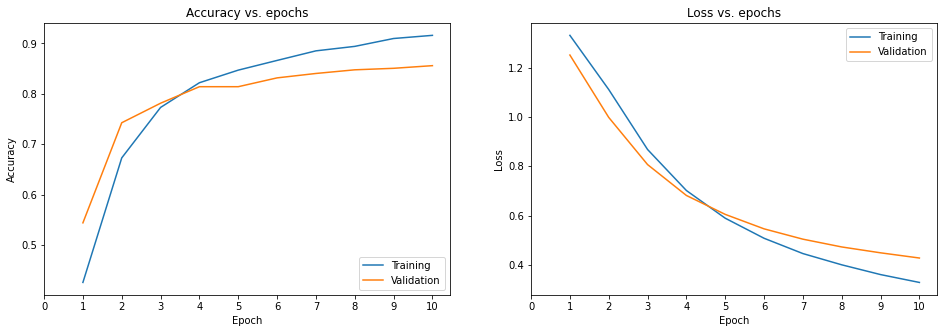

In [26]:
history = helper.train(model)

---------------------------------------- evaluate ----------------------------------------
load best checkpoint from ./models/reuters/stack_overflow_16k_0329_p100/embedding
learning_rate=0.001
checkpoint_path=./models/reuters/stack_overflow_16k_0329_p100/embedding
250/250 [==============================] - 2s 7ms/step - loss: 0.4284 - accuracy: 0.8559 - sparse_top_k_categorical_accuracy: 0.9515
loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/models/reuters/stack_overflow_16k_0329_p100/embedding
loading load_vectorizer from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/models/reuters/stack_overflow_16k_0329_p100/SequenceTextDatasets.vectorizer
save object to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/models/reuters/stack_overflow_16k_0329_p100/embedding.predictor
--------------------------------------------------------------------------------
test loss:0.4284
test accuracy:0.8559
test sparse_top_k_categorical_accuracy:0.9515
---

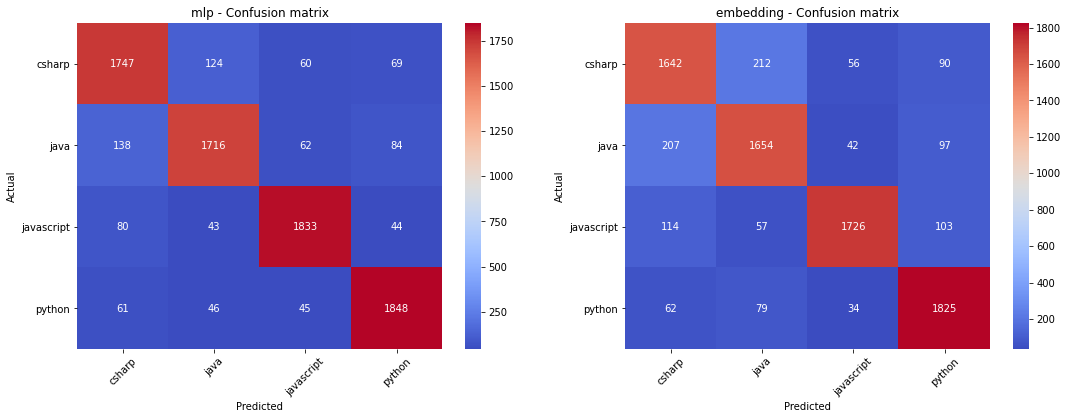

---------------------------------------- error analysis ----------------------------------------
250/250 [==============================] - 1s 5ms/step
........................................ csharp ........................................
"is there any penalty between appending string vs char in blank when developing in java a couple of years ago i learned that it is better to append a char if i had a single character instead of a string with one character because the vm would not have to do any lookup on the string value in its internal string pool...string stringappend = ""hello "" + name + "".""; .string charappend = ""hello "" + name + '.'; // better?...when i started programming in blank i never thought of the chance that it would be the same with its ""vm"". i came across blank string theory—string intern pool that states that blank also has an internal string pool (i guess it would be weird if it didn't) so my question is,..are there actually any benefits in appending a char i

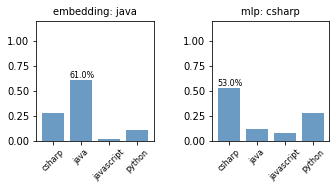

........................................ python ........................................
"what is blank's fabric equivalent in other languages? can someone tell me what's the equivalent of blank's fabric in blank itself, other languages or third party tools?  i am still a bit fuzzy on what it is trying to accomplish and it's usage."



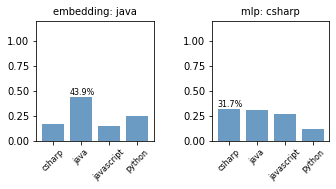

........................................ csharp ........................................
"lining up multiplication table private void multibtn_click(object sender, eventargs e).{.    for (int a = 1; a &lt;= 10; a++).        for (int b = 1; b &lt;= 10; b++).            lbltable.text = (a + "" * "" + b + "" = "" + (a * b));..    for (int a = 1; a &lt;= 10; a++).        for (int b = 1; b &lt;= 10; b++) .            lbltable.text += (a + "" * "" + b + "" = "" + (a * b));.}...it's doing exactly what i want it to do when it comes to multiplying. it's just not lined up in rows. it prints out the multiplication for integers 1 to 10. i just need them in rows and columns, could anyone explain to me how to do that through a label.  really don't know how to explain what it's doing but in my gui it prints out like ""10*10=1001*1=11*2=21*3=3"" and so on it just keeps going like that. i'm not even sure why it starts out with 10*10=100"



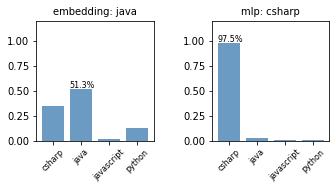

........................................ csharp ........................................
"adding an integer number to a unicode character - what does this do? i am learning blank in the beginners level. i do not understand what adding an integer number to a unicode character does. what does the addition do in the example below?..int amount = int.parse(number.text);.steps.text = """";.string current = """";.do.{.    int nextdigit = amount % 8;.    amount /= 8;.    int digitcode = '0' + nextdigit;.    char digit = convert.tochar(digitcode);.    current = digit + current;.    steps.text += current + ""n"";.}.while (amount != 0);"



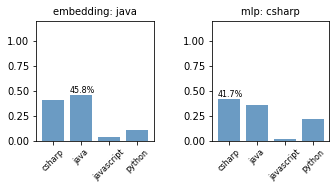

........................................ csharp ........................................
how do i start in blank a function that's async from a function that isn't? i have a function that isn't async and as a result i can't use await. in that function i call a function that's async...my coworker suggested i use:..private void foo().{.   var _ = barasync();.}...this way however has the disadvantage that i don't get notified when the function throws errors. is there a better way to call the function? i don't care whether or not the function gets executed asyncronly.



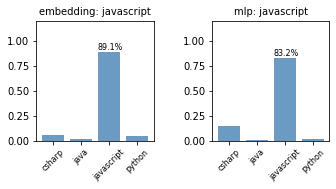

-------------------------------------------------- all models --------------------------------------------------


,weight_number,train_time,train_loss,test_loss,train_accuracy,test_accuracy,train_sparse_top_k_categorical_accuracy,test_sparse_top_k_categorical_accuracy
mlp,5121284,59.0,0.1314,0.2961,0.9722,0.8930,0.9744,0.9592
embedding,4001004,99.0,0.3034,0.4284,0.9305,0.8559,0.9640,0.9515


save json to ./models/reuters/stack_overflow_16k_0329_p100/model_results.json


In [27]:
helper.model_summary(model, history=history)

### sepCNN

In [28]:
def get_sepcnn(helper,
                 blocks=1,
                 filters=64,
                 kernel_size=3,
                 embedding_dim=200,
                 dropout=None,
                 pool_size=3,
                 use_pretrained_embedding=False,
                 is_embedding_trainable=False,
                 embedding_matrix=None, 
                 name='sepcnn'
                ):
    """Creates an instance of a separable CNN model.

    # Arguments
        blocks: int, number of pairs of sepCNN and pooling blocks in the model.
        filters: int, output dimension of the layers.
        kernel_size: int, length of the convolution window.
        embedding_dim: int, dimension of the embedding vectors.
        dropout: float, percentage of input to drop at Dropout layers.
        pool_size: int, factor by which to downscale input at MaxPooling layer.
        input_shape: tuple, shape of input to the model.
        num_classes: int, number of output classes.
        num_features: int, number of words (embedding input dimension).
        use_pretrained_embedding: bool, true if pre-trained embedding is on.
        is_embedding_trainable: bool, true if embedding layer is trainable.
        embedding_matrix: dict, dictionary with embedding coefficients.

    # Returns
        A sepCNN model instance.
    """
    if dropout is None:
        dropout = helper.get_model_param(name, 'dropout')
        
    input_shape = helper.datasets.input_shape
    num_classes = len(helper.params.classes)
    num_features = helper.params.max_features+1  
    
    model = models.Sequential(name=name)

    # Add embedding layer. If pre-trained embedding is used add weights to the
    # embeddings layer and set trainable to input is_embedding_trainable flag.
    if use_pretrained_embedding:
        model.add(layers.Embedding(input_dim=num_features,
                                   output_dim=embedding_dim,
                                   input_length=input_shape[0],
                                   weights=[embedding_matrix],
                                   trainable=is_embedding_trainable))
    else:
        model.add(layers.Embedding(input_dim=num_features,
                                   output_dim=embedding_dim,
                                   input_length=input_shape[0]))

    for i in range(blocks):
        model.add(layers.Dropout(rate=dropout))
        if i==blocks-1: filters=filters*2
        model.add(layers.SeparableConv1D(filters=filters,
                                         kernel_size=kernel_size,
                                         activation='relu',
                                         bias_initializer='random_uniform',
                                         depthwise_initializer='random_uniform',
                                         padding='same'))
        model.add(layers.SeparableConv1D(filters=filters,     
                                         kernel_size=kernel_size,
                                         activation='relu',
                                         bias_initializer='random_uniform',
                                         depthwise_initializer='random_uniform',
                                         padding='same'))
        model.add(layers.MaxPooling1D(pool_size=pool_size))

    model.add(layers.GlobalAveragePooling1D())
    if dropout>0: model.add(layers.Dropout(rate=dropout))
    model.add(layers.Dense(num_classes))
    helper.compile(model)  
    return model


helper = TextClassificationHelper(params, model_results=model_results, datasets=sequence_datasets)
model = get_sepcnn(helper, blocks=1)
# when bolcks=2, the model can't converg
model.summary()

model_params.sepcnn.dropout=0.4
learning_rate=0.001
checkpoint_path=./models/reuters/stack_overflow_16k_0329_p100/sepcnn
Model: "sepcnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 200)          4000200   
_________________________________________________________________
dropout_3 (Dropout)          (None, 500, 200)          0         
_________________________________________________________________
separable_conv1d (SeparableC (None, 500, 128)          26328     
_________________________________________________________________
separable_conv1d_1 (Separabl (None, 500, 128)          16896     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 166, 128)          0         
_________________________________________________________________
global_average_pooling1d_1 ( (None, 128)               0         
_____

2021-04-02 17:46:50,686: INFO: start training


model_params.sepcnn.epochs=10
use ModelCheckpoint(filepath=./models/reuters/stack_overflow_16k_0329_p100/sepcnn, monitor=val_accuracy)
use EarlyStopping(monitor=val_accuracy, patience=40)
use ReduceLROnPlateau(monitor=val_loss, factor=0.31622776601683794, patience=15)
use LearningRateScheduler()
Epoch 1/10
250/250 [==============================] - ETA: 0s - loss: 1.3816 - accuracy: 0.2612 - sparse_top_k_categorical_accuracy: 0.7306INFO:tensorflow:Assets written to: ./models/reuters/stack_overflow_16k_0329_p100/sepcnn/assets


2021-04-02 17:47:07,070: INFO: Assets written to: ./models/reuters/stack_overflow_16k_0329_p100/sepcnn/assets


250/250 [==============================] - 13s 54ms/step - loss: 1.3816 - accuracy: 0.2612 - sparse_top_k_categorical_accuracy: 0.7306 - val_loss: 1.3268 - val_accuracy: 0.3241 - val_sparse_top_k_categorical_accuracy: 0.5945
Epoch 2/10
250/250 [==============================] - ETA: 0s - loss: 0.8953 - accuracy: 0.6121 - sparse_top_k_categorical_accuracy: 0.8581INFO:tensorflow:Assets written to: ./models/reuters/stack_overflow_16k_0329_p100/sepcnn/assets


2021-04-02 17:47:20,288: INFO: Assets written to: ./models/reuters/stack_overflow_16k_0329_p100/sepcnn/assets


250/250 [==============================] - 13s 52ms/step - loss: 0.8953 - accuracy: 0.6121 - sparse_top_k_categorical_accuracy: 0.8581 - val_loss: 0.6283 - val_accuracy: 0.7659 - val_sparse_top_k_categorical_accuracy: 0.9180
Epoch 3/10
250/250 [==============================] - ETA: 0s - loss: 0.4961 - accuracy: 0.8050 - sparse_top_k_categorical_accuracy: 0.9438INFO:tensorflow:Assets written to: ./models/reuters/stack_overflow_16k_0329_p100/sepcnn/assets


2021-04-02 17:47:33,270: INFO: Assets written to: ./models/reuters/stack_overflow_16k_0329_p100/sepcnn/assets


250/250 [==============================] - 13s 52ms/step - loss: 0.4961 - accuracy: 0.8050 - sparse_top_k_categorical_accuracy: 0.9438 - val_loss: 0.4919 - val_accuracy: 0.8256 - val_sparse_top_k_categorical_accuracy: 0.9416
Epoch 4/10
250/250 [==============================] - ETA: 0s - loss: 0.3393 - accuracy: 0.8770 - sparse_top_k_categorical_accuracy: 0.9691INFO:tensorflow:Assets written to: ./models/reuters/stack_overflow_16k_0329_p100/sepcnn/assets


2021-04-02 17:47:46,074: INFO: Assets written to: ./models/reuters/stack_overflow_16k_0329_p100/sepcnn/assets


250/250 [==============================] - 13s 51ms/step - loss: 0.3393 - accuracy: 0.8770 - sparse_top_k_categorical_accuracy: 0.9691 - val_loss: 0.4551 - val_accuracy: 0.8426 - val_sparse_top_k_categorical_accuracy: 0.9456
Epoch 5/10
249/250 [============================>.] - ETA: 0s - loss: 0.2399 - accuracy: 0.9150 - sparse_top_k_categorical_accuracy: 0.9797INFO:tensorflow:Assets written to: ./models/reuters/stack_overflow_16k_0329_p100/sepcnn/assets


2021-04-02 17:47:58,992: INFO: Assets written to: ./models/reuters/stack_overflow_16k_0329_p100/sepcnn/assets


250/250 [==============================] - 13s 51ms/step - loss: 0.2395 - accuracy: 0.9151 - sparse_top_k_categorical_accuracy: 0.9797 - val_loss: 0.4670 - val_accuracy: 0.8504 - val_sparse_top_k_categorical_accuracy: 0.9471
Epoch 6/10
249/250 [============================>.] - ETA: 0s - loss: 0.1839 - accuracy: 0.9367 - sparse_top_k_categorical_accuracy: 0.9873INFO:tensorflow:Assets written to: ./models/reuters/stack_overflow_16k_0329_p100/sepcnn/assets


2021-04-02 17:48:12,332: INFO: Assets written to: ./models/reuters/stack_overflow_16k_0329_p100/sepcnn/assets


250/250 [==============================] - 13s 53ms/step - loss: 0.1835 - accuracy: 0.9369 - sparse_top_k_categorical_accuracy: 0.9872 - val_loss: 0.4913 - val_accuracy: 0.8549 - val_sparse_top_k_categorical_accuracy: 0.9455
Epoch 7/10
250/250 [==============================] - 11s 44ms/step - loss: 0.1404 - accuracy: 0.9569 - sparse_top_k_categorical_accuracy: 0.9911 - val_loss: 0.5711 - val_accuracy: 0.8501 - val_sparse_top_k_categorical_accuracy: 0.9446
Epoch 8/10
250/250 [==============================] - 11s 45ms/step - loss: 0.1102 - accuracy: 0.9646 - sparse_top_k_categorical_accuracy: 0.9933 - val_loss: 0.6088 - val_accuracy: 0.8478 - val_sparse_top_k_categorical_accuracy: 0.9444
Epoch 9/10
250/250 [==============================] - 11s 44ms/step - loss: 0.0889 - accuracy: 0.9689 - sparse_top_k_categorical_accuracy: 0.9961 - val_loss: 0.6336 - val_accuracy: 0.8521 - val_sparse_top_k_categorical_accuracy: 0.9436
Epoch 10/10
250/250 [==============================] - 11s 45ms/ste

2021-04-02 17:48:57,399: INFO: finish training [elapsed time: 126.71 seconds]


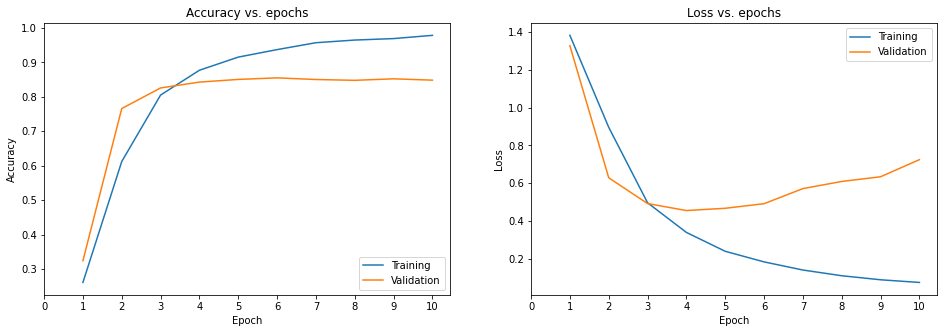

In [29]:
history = helper.train(model, batch_size=32)

---------------------------------------- evaluate ----------------------------------------
load best checkpoint from ./models/reuters/stack_overflow_16k_0329_p100/sepcnn
learning_rate=0.001
checkpoint_path=./models/reuters/stack_overflow_16k_0329_p100/sepcnn
250/250 [==============================] - 2s 7ms/step - loss: 0.4913 - accuracy: 0.8549 - sparse_top_k_categorical_accuracy: 0.9455
loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/models/reuters/stack_overflow_16k_0329_p100/sepcnn
loading load_vectorizer from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/models/reuters/stack_overflow_16k_0329_p100/SequenceTextDatasets.vectorizer
save object to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/models/reuters/stack_overflow_16k_0329_p100/sepcnn.predictor
--------------------------------------------------------------------------------
test loss:0.4913
test accuracy:0.8549
test sparse_top_k_categorical_accuracy:0.9455
---------------

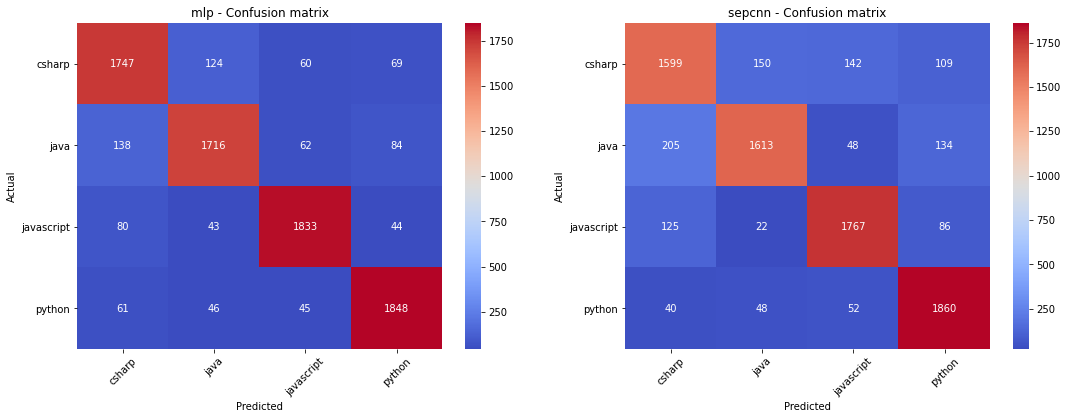

---------------------------------------- error analysis ----------------------------------------
250/250 [==============================] - 1s 6ms/step
........................................ python ........................................
"blank: how to load (substitute) attribute name from list i would like to improve this piece of code:..class opt_variable:..       pass..var = opt_variable..list = [""name"", ""value""]..var.list[0] = ""xxx""...i got this message:..attributeerror: type object 'opt_variable' has no attribute 'list'...i would like to use attribute name called from the previously defined list."



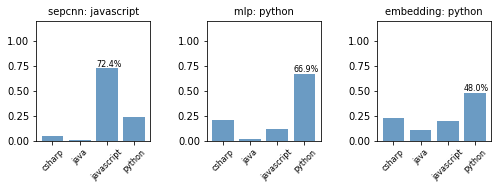

........................................ csharp ........................................
"how to know the given date is utc or local in blank i am passing the date like datetimeoffset in postman and i just want to find out the date is utc or local,..{.  ""fromdate"": ""2019-11-06t09:55:51.695z"",.  ""todate"": ""2019-11-06t09:55:51.695z"".}...what i have tried is ,..var fromdatekind = fromdate.utcdatetime.kind;..var todatekind = todate.utcdatetime.kind;...i need to check the given fromdate and todate is utc,.how to know the given date is utc or local"



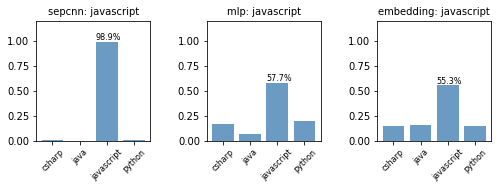

........................................ csharp ........................................
"casting - what's the difference between ""(myobject)something"" and ""something as myobject"" in blank? i've encountered this a couple of times and been perplexed...cat c = new cat(""fluffy"");.return (animal)c;..cat c = new cat(""fluffy"");.return c as animal;...what's the reason for both of these syntaxes to exist?"



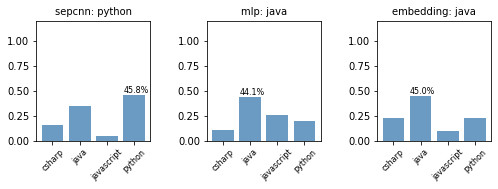

........................................ python ........................................
"blank webbrowser library i happened run into a blank standard library, &lt;webbrowser>. i tried the example there, and it opened up a new browser and went to the page i wanted. however, there is isn't any further extra functions from the package, like close, switch tab, etc...blank -m webbrowser -t ""http://www.blank.org""...is that all the library does or it is just me underestimating the true power of this package?"



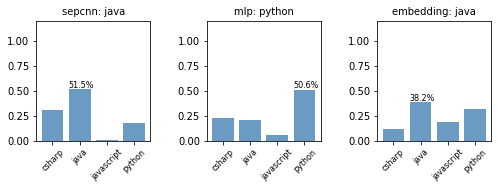

........................................ java ........................................
"make jlist visible even if there isn't anything to display i am working on an assignment which requires the use of jlist. ..basically it is an ordering shopping cart. i have 2 lists: one which has all of the items available to be purchased, and a second which holds the items that are ""added"" to the cart. it all works pretty well. however, i am having a tough time figuring out how to display the empty cart list when there aren't any items in it yet. i have an empty panel until it's filled. ..how can i make it visible all the time?"



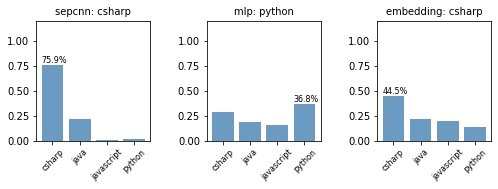

-------------------------------------------------- all models --------------------------------------------------


,weight_number,train_time,train_loss,test_loss,train_accuracy,test_accuracy,train_sparse_top_k_categorical_accuracy,test_sparse_top_k_categorical_accuracy
mlp,5121284,59.0,0.1314,0.2961,0.9722,0.8930,0.9744,0.9592
embedding,4001004,99.0,0.3034,0.4284,0.9305,0.8559,0.9640,0.9515
sepcnn,4043940,126.0,0.1121,0.4913,0.9684,0.8549,0.9683,0.9455


save json to ./models/reuters/stack_overflow_16k_0329_p100/model_results.json


In [30]:
helper.model_summary(model, history=history)

### LSTM

In [31]:
def get_lstm(helper, name='rnn_lstm', dropout=None):
    if dropout is None:
        dropout = helper.get_model_param(name, 'dropout')   

    units = helper.get_model_param(name, 'units')
    max_features = helper.get_model_param(name, 'max_features')
    embedding_dim = helper.get_model_param(name, 'embedding_dim') 
    
    input = layers.Input(shape=helper.datasets.input_shape)
    x = layers.Embedding(input_dim=max_features+1, output_dim=embedding_dim, mask_zero=True)(input)
    x = layers.LSTM(units=units)(x)
    if dropout>0: x = layers.Dropout(dropout)(x)
    x = layers.Dense(len(helper.params.classes))(x)  
    model = Model(inputs=input, outputs=x, name=name) 
    helper.compile(model)      
    return model 

helper = TextClassificationHelper(params, model_results=model_results, datasets=sequence_datasets)
model = get_lstm(helper)
model.summary()

model_params.rnn_lstm.dropout=0.3
model_params.rnn_lstm.units=200
max_features=20000
model_params.rnn_lstm.embedding_dim=200
learning_rate=0.001
checkpoint_path=./models/reuters/stack_overflow_16k_0329_p100/rnn_lstm
Model: "rnn_lstm"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 500)]             0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 500, 200)          4000200   
_________________________________________________________________
lstm (LSTM)                  (None, 200)               320800    
_________________________________________________________________
dropout_5 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 4)                 804       
Total params: 4,321,804
Trainable params

2021-04-02 17:49:15,512: INFO: start training


model_params.rnn_lstm.epochs=5
use ModelCheckpoint(filepath=./models/reuters/stack_overflow_16k_0329_p100/rnn_lstm, monitor=val_accuracy)
use EarlyStopping(monitor=val_accuracy, patience=40)
use ReduceLROnPlateau(monitor=val_loss, factor=0.31622776601683794, patience=15)
use LearningRateScheduler()
Epoch 1/5
250/250 [==============================] - ETA: 0s - loss: 1.2622 - accuracy: 0.4381 - sparse_top_k_categorical_accuracy: 0.8166INFO:tensorflow:Assets written to: ./models/reuters/stack_overflow_16k_0329_p100/rnn_lstm/assets


2021-04-02 17:53:06,703: INFO: Assets written to: ./models/reuters/stack_overflow_16k_0329_p100/rnn_lstm/assets


250/250 [==============================] - 226s 902ms/step - loss: 1.2622 - accuracy: 0.4381 - sparse_top_k_categorical_accuracy: 0.8166 - val_loss: 1.2992 - val_accuracy: 0.3654 - val_sparse_top_k_categorical_accuracy: 0.6359
Epoch 2/5
250/250 [==============================] - ETA: 0s - loss: 1.0938 - accuracy: 0.5229 - sparse_top_k_categorical_accuracy: 0.7772INFO:tensorflow:Assets written to: ./models/reuters/stack_overflow_16k_0329_p100/rnn_lstm/assets


2021-04-02 17:56:14,581: INFO: Assets written to: ./models/reuters/stack_overflow_16k_0329_p100/rnn_lstm/assets


250/250 [==============================] - 187s 749ms/step - loss: 1.0938 - accuracy: 0.5229 - sparse_top_k_categorical_accuracy: 0.7772 - val_loss: 0.9488 - val_accuracy: 0.6252 - val_sparse_top_k_categorical_accuracy: 0.8253
Epoch 3/5
250/250 [==============================] - 169s 676ms/step - loss: 1.0975 - accuracy: 0.5268 - sparse_top_k_categorical_accuracy: 0.7820 - val_loss: 1.0070 - val_accuracy: 0.5726 - val_sparse_top_k_categorical_accuracy: 0.8173
Epoch 4/5
250/250 [==============================] - ETA: 0s - loss: 0.8684 - accuracy: 0.6637 - sparse_top_k_categorical_accuracy: 0.8490INFO:tensorflow:Assets written to: ./models/reuters/stack_overflow_16k_0329_p100/rnn_lstm/assets


2021-04-02 18:01:59,271: INFO: Assets written to: ./models/reuters/stack_overflow_16k_0329_p100/rnn_lstm/assets


250/250 [==============================] - 175s 699ms/step - loss: 0.8684 - accuracy: 0.6637 - sparse_top_k_categorical_accuracy: 0.8490 - val_loss: 0.8907 - val_accuracy: 0.6629 - val_sparse_top_k_categorical_accuracy: 0.8306
Epoch 5/5
250/250 [==============================] - ETA: 0s - loss: 0.7232 - accuracy: 0.7475 - sparse_top_k_categorical_accuracy: 0.8905INFO:tensorflow:Assets written to: ./models/reuters/stack_overflow_16k_0329_p100/rnn_lstm/assets


2021-04-02 18:04:53,037: INFO: Assets written to: ./models/reuters/stack_overflow_16k_0329_p100/rnn_lstm/assets


250/250 [==============================] - 173s 693ms/step - loss: 0.7232 - accuracy: 0.7475 - sparse_top_k_categorical_accuracy: 0.8905 - val_loss: 0.7348 - val_accuracy: 0.7368 - val_sparse_top_k_categorical_accuracy: 0.8873


2021-04-02 18:04:53,812: INFO: finish training [elapsed time: 938.30 seconds]


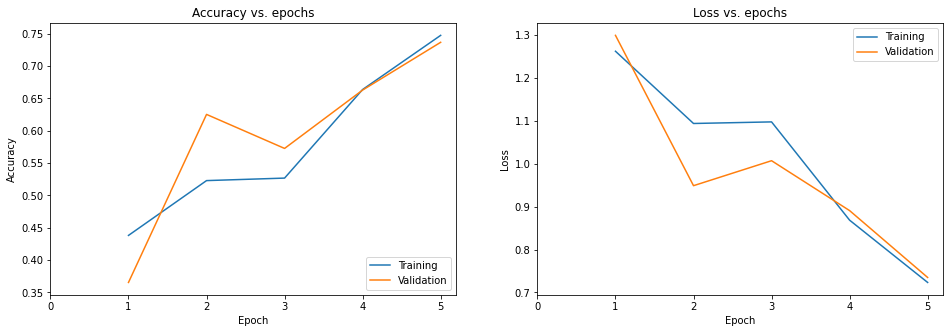

In [32]:
history = helper.train(model)

---------------------------------------- evaluate ----------------------------------------
load best checkpoint from ./models/reuters/stack_overflow_16k_0329_p100/rnn_lstm
learning_rate=0.001
checkpoint_path=./models/reuters/stack_overflow_16k_0329_p100/rnn_lstm
250/250 [==============================] - 31s 123ms/step - loss: 0.7348 - accuracy: 0.7368 - sparse_top_k_categorical_accuracy: 0.8873
loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/models/reuters/stack_overflow_16k_0329_p100/rnn_lstm
loading load_vectorizer from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/models/reuters/stack_overflow_16k_0329_p100/SequenceTextDatasets.vectorizer
save object to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/models/reuters/stack_overflow_16k_0329_p100/rnn_lstm.predictor
--------------------------------------------------------------------------------
test loss:0.7348
test accuracy:0.7368
test sparse_top_k_categorical_accuracy:0.8873
----

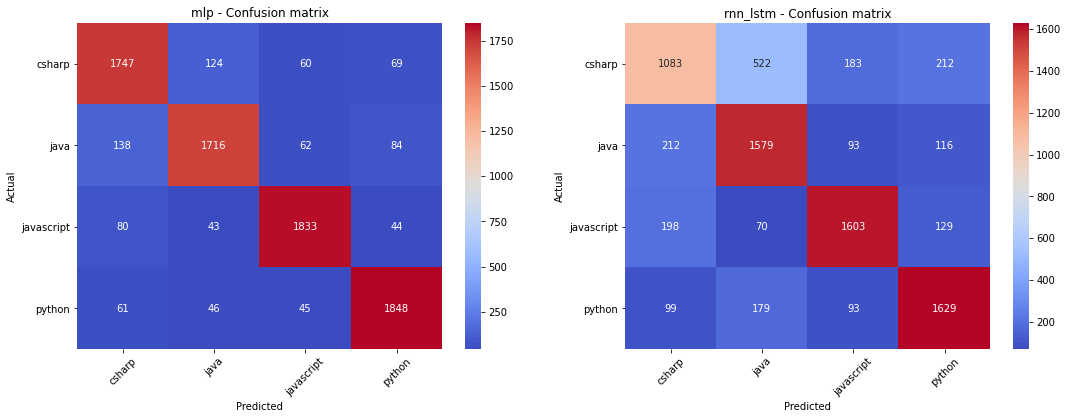

---------------------------------------- error analysis ----------------------------------------
250/250 [==============================] - 31s 123ms/step
........................................ csharp ........................................
"call parent form method when returning to parent form from child form how do i call a method loadgrid located in a parent form frmmain when returning to frmmain from a child form?  ..in frmmain the method loadgrid is run at frmmain load time to populate a data grid view.  a stored procedure is used in loadgrid to pull the certain (not all) records from sql data to populate the dgv.  once frmmain is loaded, it is never loaded again, so loadgrid is never run again and my dgv is never refreshed...i have created a button on frmmain that will run loadgrid.  it works fine, but this takes manual intervention.  ..my child form is used to approve/clear records that are shown on the frmmain dgv.  when returning from the child form, i would like the dgv on

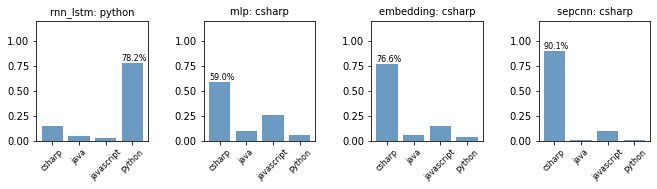

........................................ csharp ........................................
"blank match user inputs to array i'm writing some code where i have some information about customers stored in an array called members (id, initials). i then ask the user for their id and initials and match the inputs to the stored information from array members. if they match i move on. however i get an error in my coding: ""an object reference is required to access non-static field method or property"". the error comes from the if statements. any suggestions on how to correct this issue?..some background info: i have two classes, one called customer and one called menu. the menu is the main class while customer is the class i reference from. ..this is from my menu class:..       int l = 0; .       string i = """";.       customer[] members = new customer[2];.        members[0] = new customer(3242, ""js"");.        members[1] = new customer(7654, ""bj"");..        console.write(""nwhat is your lo

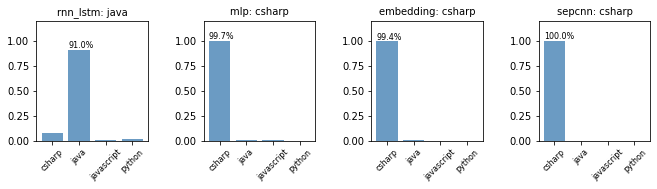

........................................ csharp ........................................
"setting next and previous properties i have a list of tokens which are generated by the tokeniser...list&lt;token&gt; tokenlist = new list&lt;token&gt;();...and here's the token class...public class token.{.    public tokens tokenname { get; set; }..    public string tokenvalue { get; set; }..    public token previous {.        get; set;.    }..    public token next {.        get; set;.    }..    public token(tokens name, string value).    {.        tokenname = name;.        tokenvalue = value;.    }.}...and i need to set the next and previous properties of each token in the list but avoid them to point newline or whitespace or tabspace tokens but use their next ones...here's my code...token token = null;..foreach (token tkn in tokenlist).{.    if (token != null).    {.        switch (token.tokenname).        {.            case tokens.newline:.            case tokens.whitespace:.            case t

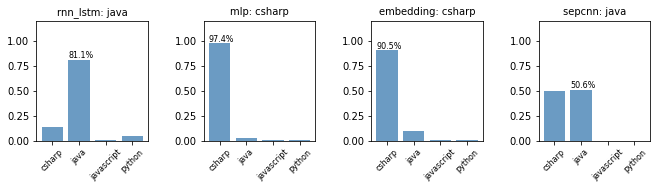

........................................ java ........................................
"how to swap digits from a integer in blank using bitwise operator? what i am trying to do is swapping the numbers, for example 27 to 72. i tried the code below without any luck...static int reverse(int a){.    int r = 0x0ff &amp; a;.    r &lt;&lt;= 4; a &gt;&gt;= 4;.    r |= 0x0ff &amp; a;.    return r;.}"



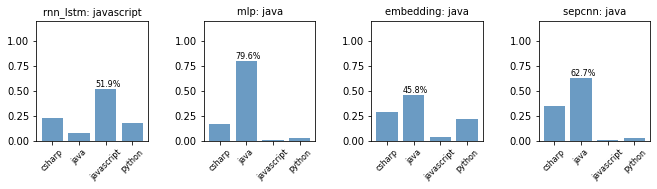

........................................ csharp ........................................
"blank dll path @ runtime i am new to blank, need help in the following situation..i have created an executable application (.exe) in blank. the application depends on certain c++ dlls. hence i have used dllimport method - with the local path  to execute the application. .when i am executing the .exe as such (without blank) the application works if the dll are placed in the same level of .exe. ..i want to place all the dlls in an folder named dll and place the folder next to .exe. now the dllimport will not recognize the path. now how do i write my code to pick the current path at run time for the .exe is executed independently...i tried the below code it does not work. basically it just throws compilation error. since new to blank, though seen many online answers i am sorry not able to get a solution. please help me with this..[dllimport(system.windows.forms.application.startuppath + ""\ap4600_sdk

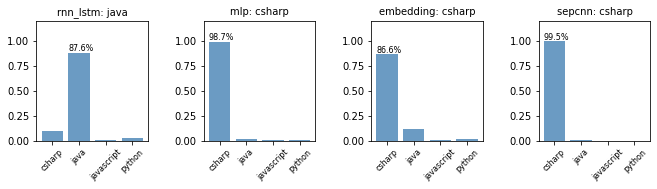

-------------------------------------------------- all models --------------------------------------------------


,weight_number,train_time,train_loss,test_loss,train_accuracy,test_accuracy,train_sparse_top_k_categorical_accuracy,test_sparse_top_k_categorical_accuracy
mlp,5121284,59.0,0.1314,0.2961,0.9722,0.8930,0.9744,0.9592
embedding,4001004,99.0,0.3034,0.4284,0.9305,0.8559,0.9640,0.9515
sepcnn,4043940,126.0,0.1121,0.4913,0.9684,0.8549,0.9683,0.9455
rnn_lstm,4321804,938.0,0.4495,0.7348,0.8464,0.7368,0.9166,0.8873


save json to ./models/reuters/stack_overflow_16k_0329_p100/model_results.json


In [33]:
helper.model_summary(model, history=history)

### LSTM + Bidirectional + Stacked

In [37]:
def get_lstm_stacked(helper, name='rnn_lstm_stacked', dropout=None):
    if dropout is None:
        dropout = helper.get_model_param(name, 'dropout')   
    
    units = helper.get_model_param(name, 'units')
    max_features = helper.get_model_param(name, 'max_features')
    embedding_dim = helper.get_model_param(name, 'embedding_dim') 
    
    input = layers.Input(shape=helper.datasets.input_shape)
    x = layers.Embedding(input_dim=max_features+1, output_dim=embedding_dim, mask_zero=True)(input)
    x = layers.Bidirectional(layers.LSTM(units=units, return_sequences=True))(x)
    x = layers.LSTM(units=units)(x)
    if dropout>0: x = layers.Dropout(dropout)(x)
    x = layers.Dense(len(helper.params.classes))(x)  
    model = Model(inputs=input, outputs=x, name=name) 
    helper.compile(model)      
    return model 

helper = TextClassificationHelper(params, model_results=model_results, datasets=sequence_datasets)
model = get_lstm_stacked(helper)
model.summary()

model_params.rnn_lstm_stacked.dropout=0.3
model_params.rnn_lstm_stacked.units=200
max_features=20000
model_params.rnn_lstm_stacked.embedding_dim=200
learning_rate=0.001
checkpoint_path=./models/reuters/stack_overflow_16k_0329_p100/rnn_lstm_stacked
Model: "rnn_lstm_stacked"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 500)]             0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 500, 200)          4000200   
_________________________________________________________________
bidirectional (Bidirectional (None, 500, 400)          641600    
_________________________________________________________________
lstm_2 (LSTM)                (None, 200)               480800    
_________________________________________________________________
dropout_6 (Dropout)          (None, 200)               0         


2021-04-02 18:15:25,406: INFO: start training


model_params.rnn_lstm_stacked.epochs=5
use ModelCheckpoint(filepath=./models/reuters/stack_overflow_16k_0329_p100/rnn_lstm_stacked, monitor=val_accuracy)
use EarlyStopping(monitor=val_accuracy, patience=40)
use ReduceLROnPlateau(monitor=val_loss, factor=0.31622776601683794, patience=15)
use LearningRateScheduler()
Epoch 1/5
250/250 [==============================] - ETA: 0s - loss: 1.1946 - accuracy: 0.4550 - sparse_top_k_categorical_accuracy: 0.7955INFO:tensorflow:Assets written to: ./models/reuters/stack_overflow_16k_0329_p100/rnn_lstm_stacked/assets


2021-04-02 18:24:42,708: INFO: Assets written to: ./models/reuters/stack_overflow_16k_0329_p100/rnn_lstm_stacked/assets


250/250 [==============================] - 549s 2s/step - loss: 1.1946 - accuracy: 0.4550 - sparse_top_k_categorical_accuracy: 0.7955 - val_loss: 0.7788 - val_accuracy: 0.6812 - val_sparse_top_k_categorical_accuracy: 0.8816
Epoch 2/5
250/250 [==============================] - ETA: 0s - loss: 0.7541 - accuracy: 0.6991 - sparse_top_k_categorical_accuracy: 0.9036INFO:tensorflow:Assets written to: ./models/reuters/stack_overflow_16k_0329_p100/rnn_lstm_stacked/assets


2021-04-02 18:34:24,716: INFO: Assets written to: ./models/reuters/stack_overflow_16k_0329_p100/rnn_lstm_stacked/assets


250/250 [==============================] - 581s 2s/step - loss: 0.7541 - accuracy: 0.6991 - sparse_top_k_categorical_accuracy: 0.9036 - val_loss: 0.8204 - val_accuracy: 0.7040 - val_sparse_top_k_categorical_accuracy: 0.8879
Epoch 3/5
209/250 [========================>.....] - ETA: 1:13 - loss: 0.6153 - accuracy: 0.7724 - sparse_top_k_categorical_accuracy: 0.9233INFO:tensorflow:Assets written to: ./models/reuters/stack_overflow_16k_0329_p100/rnn_lstm_stacked/assets


2021-04-02 18:44:44,216: INFO: Assets written to: ./models/reuters/stack_overflow_16k_0329_p100/rnn_lstm_stacked/assets


250/250 [==============================] - 617s 2s/step - loss: 0.5866 - accuracy: 0.7869 - sparse_top_k_categorical_accuracy: 0.9283 - val_loss: 0.5934 - val_accuracy: 0.7841 - val_sparse_top_k_categorical_accuracy: 0.9160
Epoch 4/5
250/250 [==============================] - 492s 2s/step - loss: 0.6148 - accuracy: 0.7786 - sparse_top_k_categorical_accuracy: 0.9095 - val_loss: 0.7262 - val_accuracy: 0.7788 - val_sparse_top_k_categorical_accuracy: 0.9106
Epoch 5/5
250/250 [==============================] - ETA: 0s - loss: 0.3480 - accuracy: 0.8895 - sparse_top_k_categorical_accuracy: 0.9636INFO:tensorflow:Assets written to: ./models/reuters/stack_overflow_16k_0329_p100/rnn_lstm_stacked/assets


2021-04-02 19:02:09,012: INFO: Assets written to: ./models/reuters/stack_overflow_16k_0329_p100/rnn_lstm_stacked/assets


250/250 [==============================] - 549s 2s/step - loss: 0.3480 - accuracy: 0.8895 - sparse_top_k_categorical_accuracy: 0.9636 - val_loss: 0.5327 - val_accuracy: 0.8274 - val_sparse_top_k_categorical_accuracy: 0.9283


2021-04-02 19:02:10,794: INFO: finish training [elapsed time: 2805.39 seconds]


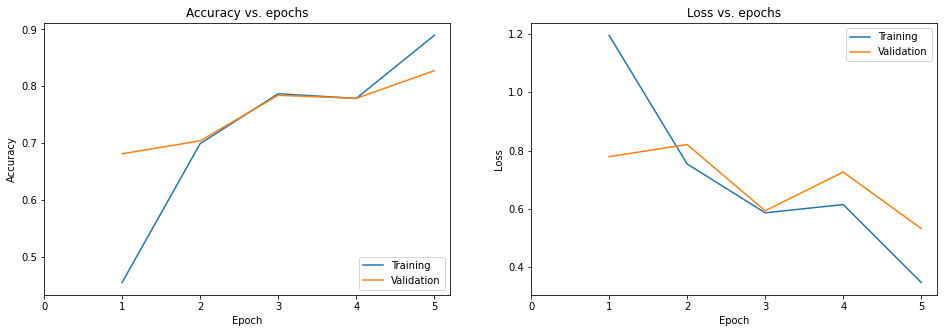

In [38]:
history = helper.train(model)

---------------------------------------- evaluate ----------------------------------------
load best checkpoint from ./models/reuters/stack_overflow_16k_0329_p100/rnn_lstm_stacked
learning_rate=0.001
checkpoint_path=./models/reuters/stack_overflow_16k_0329_p100/rnn_lstm_stacked
250/250 [==============================] - 102s 408ms/step - loss: 0.5327 - accuracy: 0.8274 - sparse_top_k_categorical_accuracy: 0.9283
loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/models/reuters/stack_overflow_16k_0329_p100/rnn_lstm_stacked
loading load_vectorizer from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/models/reuters/stack_overflow_16k_0329_p100/SequenceTextDatasets.vectorizer
save object to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/models/reuters/stack_overflow_16k_0329_p100/rnn_lstm_stacked.predictor
--------------------------------------------------------------------------------
test loss:0.5327
test accuracy:0.8274
test sparse_top_k

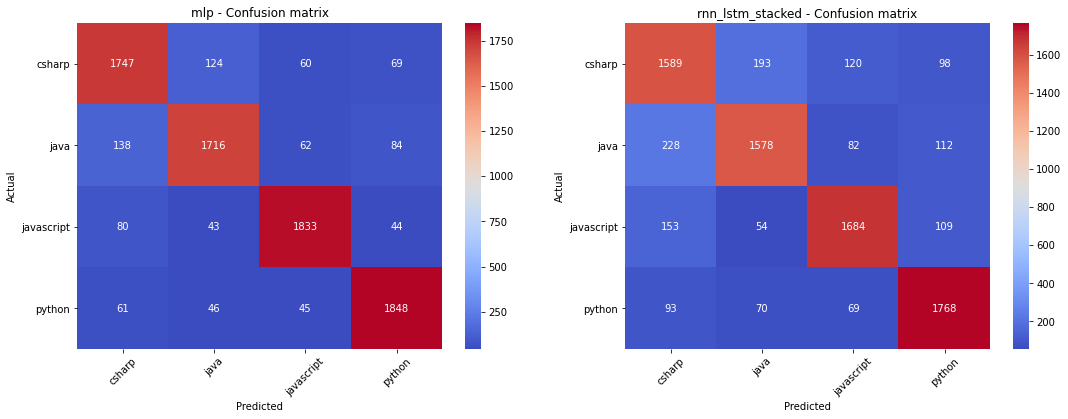

---------------------------------------- error analysis ----------------------------------------
250/250 [==============================] - 101s 406ms/step
........................................ csharp ........................................
"blank formatting text (right align) i am a beginner learning blank, i am making a mock shopping list receipt program to manage your shopping. i generate .txt receipt however having problem with right align string here is my code; ..public static void generatenewreciept(customer customer).{.    list&lt;shoppingitems&gt; customerpurchaeditems;.    try.    {.        sw = file.appendtext(""receipt.txt"");..        //customer object.        customer customers = customer;.        //list of all items in list.        list&lt;shoppinglist&gt; customeritems = customer.customershoppinglist;.        datetime todaydandt = datetime.now;..        //making reciept layout.        sw.writeline(""date generated: "" + todaydandt.tostring(""g"", cultureinfo.creates

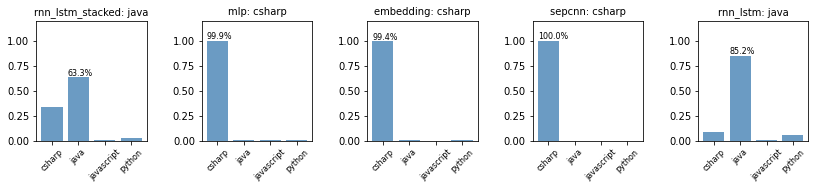

........................................ csharp ........................................
"blank rounding issue i have a double called int_step which i'm increasing every loop and expect to end when i have reached 1. however it iterates too much as rounding throws in some unexpected behaviour...for some reason the following code adds quite nicely, but close to 1 i get an offset:..            int_step += 0.01;..            // todo : fix rounding step in double with step increase of + 0.01, provides error because value will become 1.000000007.            if (int_step &gt;= 1).                int_step = 1;...can anyone explain why this happens and what the correct way is to solve this?"



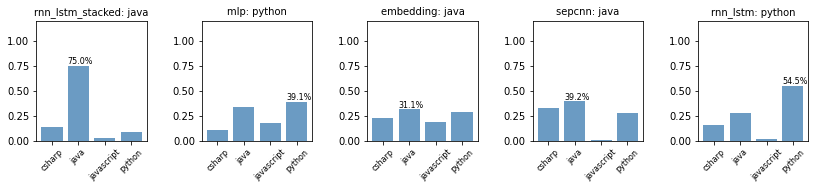

........................................ java ........................................
"problems with if-else statements and operators so, for my homework, i have to make a program that allows the user to enter in the highest amount of money they are willing to pay for a house as a whole number. here's the catch; i have to use if-else statements and joptionpane dialog boxes...so i came up with this code:..import blankx.swing.joptionpane;..public class housingdecision {  ..    public static void main(string[] args) {.         //listed things that need to be identified.         int housemoney;.         string input;.         input = joptionpane. showinputdialog(""how much money do you have?"");.         //making the input be listed by the user.         housemoney = integer. parseint(input);.         //set up so that if its more than the parameters, itll move on to the next if else statement.         if (housemoney &gt;= 250000 &amp;&amp; housemoney &lt;= 100000 );.         { .           

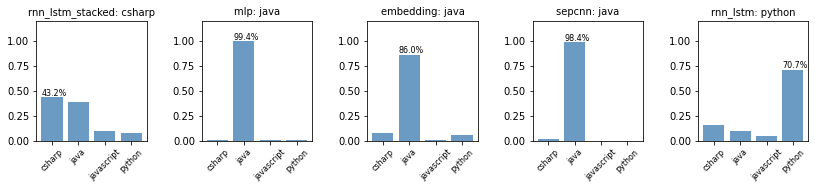

........................................ java ........................................
"create an item and bag handler for a text-based rpg for practice, i'm creating a text-based rpg using blank. i'm currently using .properties files to handle character info. i understand that yaml might be a better option, but i'm not quite sure how to implement it. using properties, it would be easy to create an inventory handler (slot1, slot2, etc.), but creating items and reading the slots for item ids is a little beyond me...could i get some assistance?..to further elaborate, i'd like to create a system with three types of items: items to be used on the environment, items to be held in hand (like weapons or shields), and items to be worn."



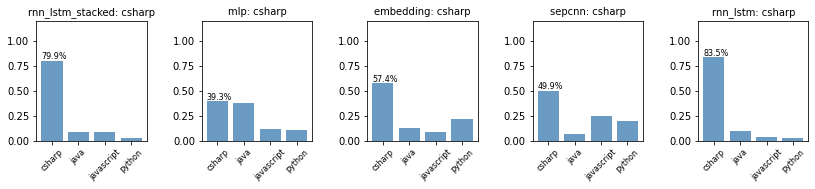

........................................ javascript ........................................
"using . in a [] to enter in a new scope let me try to explain this, i have a string like this:..""b.c""...and an object like this:..a = {.    b:{.        c:2.    }.}...i would like to use that string to get the c property, but using this doesn't work:..a[""b.c""]...how can i use the ""b.c"" string to work just like a.b.c? (without using eval, perfomance is important in my case)"



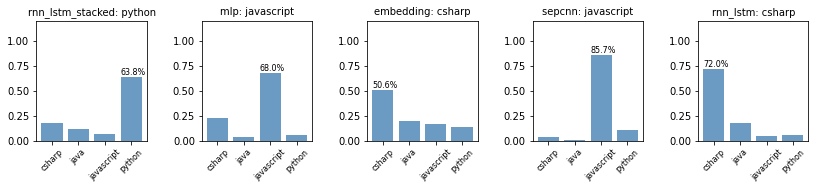

-------------------------------------------------- all models --------------------------------------------------


,weight_number,train_time,train_loss,test_loss,train_accuracy,test_accuracy,train_sparse_top_k_categorical_accuracy,test_sparse_top_k_categorical_accuracy
mlp,5121284,59.0,0.1314,0.2961,0.9722,0.8930,0.9744,0.9592
embedding,4001004,99.0,0.3034,0.4284,0.9305,0.8559,0.9640,0.9515
sepcnn,4043940,126.0,0.1121,0.4913,0.9684,0.8549,0.9683,0.9455
rnn_lstm_stacked,5123404,2805.0,0.1780,0.5327,0.9475,0.8274,0.9563,0.9283
rnn_lstm,4321804,938.0,0.4495,0.7348,0.8464,0.7368,0.9166,0.8873


save json to ./models/reuters/stack_overflow_16k_0329_p100/model_results.json


In [39]:
helper.model_summary(model, history=history)

## 参考

- [Text classification Guide](https://developers.google.com/machine-learning/guides/text-classification)